# Word2Vec (Skip-gram)
https://towardsdatascience.com/introduction-to-word2vec-skip-gram-cb3e9533bcf1

Representing words by an embedding (dense vector). Words that are similar in context have closer vectors in the vector space compared to BoW which represents words independently in a term-document matrix.
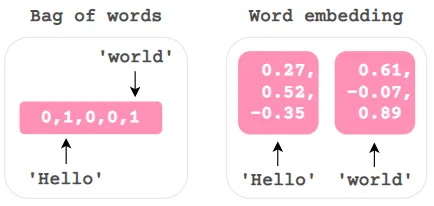

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from nltk.tokenize.regexp import RegexpTokenizer
from nltk.corpus import stopwords
from gensim.models import Word2Vec, KeyedVectors
from scipy.spatial.distance import cosine
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk')

In [2]:
# The dataset
# https://github.com/Eligijus112/word-embedding-creation/blob/cc1748f49e0547c4c2a7585624998d9a04576324/input/sample.csv
text = ["The prince is the future king.",
        "Daughter is the princess.",
        "Son is the prince.",
        "Only a man can be a king.",
        "Only a woman can be a queen.",
        "The princess will be a queen.",
        "Queen and king rule the realm.", 
        "The prince is a strong man.",
        "The princess is a beautiful woman.",
        "The royal family is the king and queen and their children.",
        "Prince is only a boy now.",
        "A boy will be a man."]

## Preprocessing the text

We will preprocess the text by lowercasing, tokenizing and removing stop words.
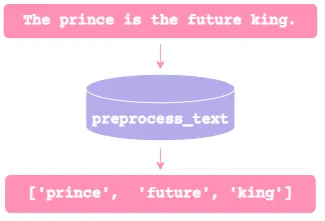

In [3]:
def preprocess_text(document):
    tokeniser = RegexpTokenizer(r"[A-Za-z]{2,}")
    tokens = tokeniser.tokenize(document.lower())
    key_tokens = [token for token in tokens 
                  if token not in stopwords.words('english')]
    return key_tokens
    
corpus = []
for document in text:
    corpus.append(preprocess_text(document))
corpus

[['prince', 'future', 'king'],
 ['daughter', 'princess'],
 ['son', 'prince'],
 ['man', 'king'],
 ['woman', 'queen'],
 ['princess', 'queen'],
 ['queen', 'king', 'rule', 'realm'],
 ['prince', 'strong', 'man'],
 ['princess', 'beautiful', 'woman'],
 ['royal', 'family', 'king', 'queen', 'children'],
 ['prince', 'boy'],
 ['boy', 'man']]

## Building Word2Vec with Gensim

+ Choose window size of 2 for the contexts. This means we consider 2 tokens before and after the focus token.
+ Set dimension as 2 which refers to the size of the vector. A dimension of 2 makes it easy to visualize the vector in a 2-D chart. We are also working with a small text corpus.
+ Specify the Skip-gram algorithm by setting sg=1

In [4]:
dimension = 2
window = 2
word2vec0 = Word2Vec(corpus, min_count=1, vector_size=dimension, 
                     window=window, sg=1)
word2vec0.wv.get_vector('king')

array([0.25516748, 0.45046365], dtype=float32)

To see how intuitive the embeddings are, we will pick the sample word 'king' and see if the words most similar to it in the vector space makes sense.

In [5]:
n=3
word2vec0.wv.most_similar(positive=['king'], topn=n)

[('man', 0.9941185712814331),
 ('realm', 0.9008388519287109),
 ('son', 0.7788274884223938)]

### Visualizing the Tokens

Let's see a DataFrame of the embeddings for the collection of unique tokens.

In [6]:
embedding0 = pd.DataFrame(columns=['d0', 'd1'])
for token in word2vec0.wv.index_to_key:
    embedding0.loc[token] = word2vec0.wv.get_vector(token)
embedding0

,d0,d1
queen,-0.026811,0.011822
king,0.255167,0.450464
prince,-0.465198,-0.355929
man,0.322944,0.448649
princess,-0.250771,-0.188169
woman,0.369025,-0.076674
boy,-0.226831,0.327703
royal,-0.243008,-0.090801
beautiful,0.143829,0.049594
strong,-0.414221,-0.472374


Now we will visualize the tokens in a 2-D vector space.

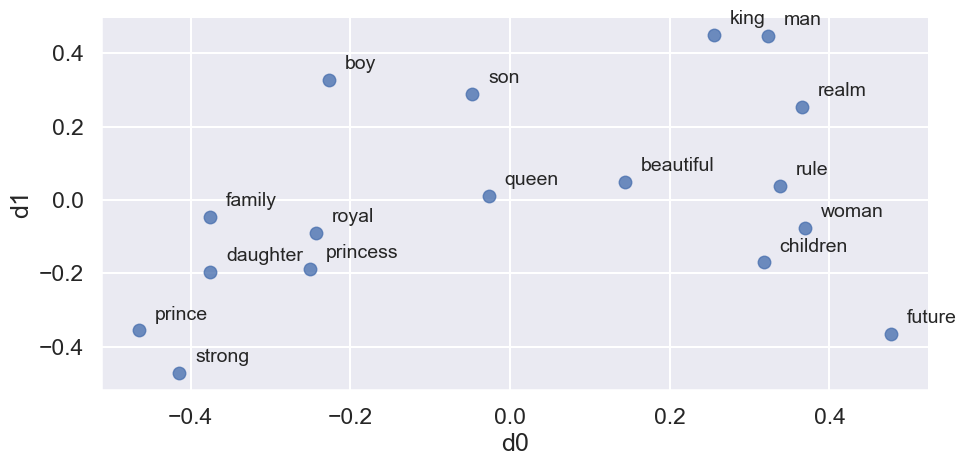

In [7]:
sns.lmplot(data=embedding0, x='d0', y='d1', fit_reg=False, aspect=2)
for token, vector in embedding0.iterrows():
    plt.gca().text(vector['d0']+.02, vector['d1']+.03, str(token), 
                   size=14)
plt.tight_layout()

## Manual Word2vec - Approach 1

First we can start by finding the vocabulary from the corpus and ssign a value to each token.

In [8]:
vocabulary = sorted([*set([token for document in corpus for token in 
                           document])])
n_vocabulary = len(vocabulary)
token_index ={token: i for i, token in enumerate(vocabulary)}
token_index

{'beautiful': 0,
 'boy': 1,
 'children': 2,
 'daughter': 3,
 'family': 4,
 'future': 5,
 'king': 6,
 'man': 7,
 'prince': 8,
 'princess': 9,
 'queen': 10,
 'realm': 11,
 'royal': 12,
 'rule': 13,
 'son': 14,
 'strong': 15,
 'woman': 16}

Next, we will make token pairs as preparation for the NN.
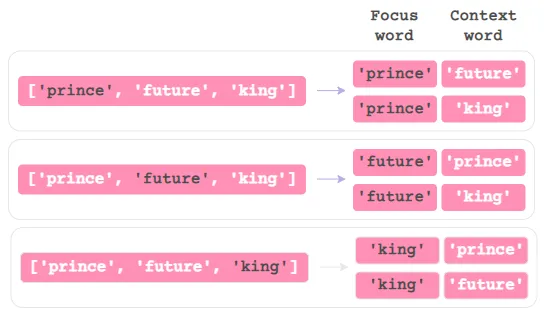

In [9]:
token_pairs = []
for document in corpus:
    for i, token in enumerate(document):
        for j in range(i-window, i+window+1):
            if (j>=0) and (j!=i) and (j<len(document)):
                token_pairs.append([token] + [document[j]])
n_token_pairs = len(token_pairs)
print(f"{n_token_pairs} token pairs")
token_pairs[:5]

56 token pairs


[['prince', 'future'],
 ['prince', 'king'],
 ['future', 'prince'],
 ['future', 'king'],
 ['king', 'prince']]

We will need to one-hot-encode the token pairs so they can be inputted into the NN.
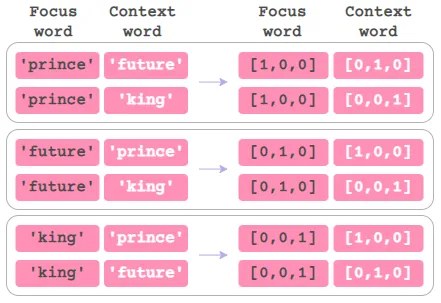

In [10]:
X = np.zeros((n_token_pairs, n_vocabulary))
Y = np.zeros((n_token_pairs, n_vocabulary))
for i, (focus_token, context_token) in enumerate(token_pairs):    
    X[i, token_index[focus_token]] = 1
    Y[i, token_index[context_token]] = 1
print(X[:5])

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### Single Hidden Layer NN

In [18]:
tf.random.set_seed(42)
word2vec1 = Sequential([
    Dense(units=dimension, input_shape=(n_vocabulary,), 
          use_bias=False, name='embedding'),
    Dense(units=n_vocabulary, activation='softmax', name='output')
])
word2vec1.compile(loss='categorical_crossentropy', optimizer='adam')
word2vec1.fit(x=X, y=Y, epochs=100)

Epoch 1/100
2/2 [==============================] - 1s 14ms/step - loss: 2.8359
Epoch 2/100
2/2 [==============================] - 0s 6ms/step - loss: 2.8339
Epoch 3/100
2/2 [==============================] - 0s 13ms/step - loss: 2.8322
Epoch 4/100
2/2 [==============================] - 0s 16ms/step - loss: 2.8305
Epoch 5/100
2/2 [==============================] - 0s 10ms/step - loss: 2.8289
Epoch 6/100
2/2 [==============================] - 0s 12ms/step - loss: 2.8272
Epoch 7/100
2/2 [==============================] - 0s 10ms/step - loss: 2.8256
Epoch 8/100
2/2 [==============================] - 0s 8ms/step - loss: 2.8240
Epoch 9/100
2/2 [==============================] - 0s 10ms/step - loss: 2.8225
Epoch 10/100
2/2 [==============================] - 0s 13ms/step - loss: 2.8208
Epoch 11/100
2/2 [==============================] - 0s 9ms/step - loss: 2.8193
Epoch 12/100
2/2 [==============================] - 0s 8ms/step - loss: 2.8177
Epoch 13/100
2/2 [==============================] - 0

In [19]:
embedding1 = pd.DataFrame(columns=['d0', 'd1'])
for token in token_index.keys():
    ind = token_index[token]
    embedding1.loc[token] = word2vec1.get_weights()[0][ind]
embedding1

,d0,d1
beautiful,0.017710,-0.237241
boy,-0.214049,-0.411805
children,0.277218,-0.250517
daughter,-0.661149,0.210613
family,0.485857,-0.388539
future,0.459573,0.333724
king,-0.396191,-0.237701
man,0.624984,0.141289
prince,0.087371,-0.282661
princess,0.275722,-0.354681


Let's see the 3 most similar words to 'king'.

In [20]:
vector1 = embedding1.loc['king']
similarities = {}
for token, vector in embedding1.iterrows():
    theta_sum = np.dot(vector1, vector)
    theta_den = np.linalg.norm(vector1) * np.linalg.norm(vector)
    similarities[token] = theta_sum / theta_den
similar_tokens = sorted(similarities.items(), key=lambda x: x[1], 
                        reverse=True)
similar_tokens[1:n+1]

[('royal', 0.9923634), ('rule', 0.9509471), ('queen', 0.9349567)]

Let's save the embeddings and load them using Genism to check our similarity calculation.

In [21]:
with open('embedding1.txt' ,'w') as text_file:
    text_file.write(f'{n_vocabulary} {dimension}\n')
    for token, vector in embedding1.iterrows():
        text_file.write(f"{token} {' '.join(map(str, vector))}\n")
text_file.close()
embedding1_loaded = KeyedVectors.load_word2vec_format('embedding1.txt', binary=False)
embedding1_loaded.most_similar(positive=['king'], topn=n)

[('royal', 0.9923633933067322),
 ('rule', 0.950947105884552),
 ('queen', 0.9349566102027893)]

### Visualizing the vector space

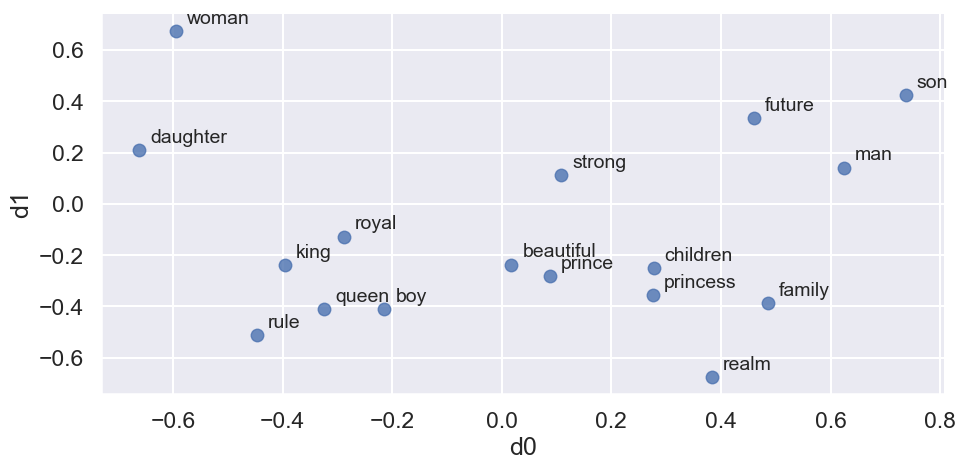

In [22]:
sns.lmplot(data=embedding1, x='d0', y='d1', fit_reg=False, aspect=2)
for token, vector in embedding1.iterrows():
    plt.gca().text(vector['d0']+.02, vector['d1']+.03, str(token), 
                   size=14)
plt.show()

## Manual Word2Vec - Approach 2

In [24]:
# Create class 'Data' which centralizes data-related tasks
class Data():
    def __init__(self, text):
        self.text = text
        self.corpus = self.extract_corpus()
    
    def preprocess_text(self, document):
        tokeniser = RegexpTokenizer(r"[A-Za-z]{2,}")
        tokens = tokeniser.tokenize(document.lower())
        key_tokens = [token for token in tokens if token not in stopwords.words('english')]
        return key_tokens
    
    def extract_corpus(self):
        corpus = []
        for document in self.text:
            corpus.append(self.preprocess_text(document))
        return corpus
    
    def one_hot_encode(self, token):
        ohe_vector = np.zeros(self.n_vocabulary)
        ohe_vector[self.token_index[token]] = 1
        return ohe_vector
    
    def prepare_focus_context_data(self, window=2):
        self.window = window
        self.vocabulary = sorted([*set([token for document in self.corpus for token in document])])
        self.n_vocabulary = len(self.vocabulary)
        self.token_index ={token: i for i, token in enumerate(self.vocabulary)}
        self.index_token = {i: token for token, i in self.token_index.items()}
        
        self.focus_context_data = []
        for sentence in self.corpus:
            for i, token in enumerate(sentence):
                focus_token = self.one_hot_encode(token)
                context_tokens = []
                for j in range(i-window, i+window+1):
                    if (j!=i) and (j<=len(sentence)-1) and (j>=0):
                        context_tokens.append(self.one_hot_encode(sentence[j]))
                self.focus_context_data.append((focus_token, context_tokens))

data = Data(text)
data.prepare_focus_context_data()
data.corpus

[['prince', 'future', 'king'],
 ['daughter', 'princess'],
 ['son', 'prince'],
 ['man', 'king'],
 ['woman', 'queen'],
 ['princess', 'queen'],
 ['queen', 'king', 'rule', 'realm'],
 ['prince', 'strong', 'man'],
 ['princess', 'beautiful', 'woman'],
 ['royal', 'family', 'king', 'queen', 'children'],
 ['prince', 'boy'],
 ['boy', 'man']]

The 'corpus' attribute is the same as in previous sections. There should be 32 tokens in our toy corpus.

In [25]:
len([token for document in data.corpus for token in document])

32

In [26]:
len(data.focus_context_data)

32

Unlike in previous sections, data.focus_context_data is not in token pair format. Each of the 32 tokens have been mapped together with all of their context tokens.
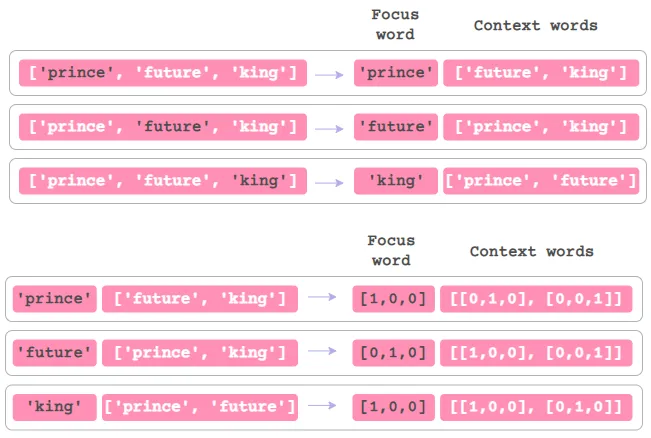

In [27]:
np.sum([len(context_tokens) for _, context_tokens in 
        data.focus_context_data])

56

We still have 56 context tokens in total. Let's centralize the code regarding Word2Vec in an object.

In [28]:
class Word2Vec():
    def __init__(self, dimension):
        self.dimension = dimension
        
    def train(self, data, learning_rate, epochs, seed=24):
        self.data = data
        np.random.seed(seed)
        self.w1 = np.random.uniform(-1, 1, (data.n_vocabulary, self.dimension))
        self.w2 = np.random.uniform(-1, 1, (self.dimension, data.n_vocabulary))

        for i in range(epochs):
            self.loss = 0
            for focus_token, context_tokens in data.focus_context_data:
                y_pred, hidden, output = self.forward_pass(focus_token)
                error = np.sum([np.subtract(y_pred, token) for token in context_tokens], axis=0)
                self.backprop(error, hidden, focus_token, learning_rate)
                self.loss += -np.sum([output[token.argmax()] for token in context_tokens]) + len(context_tokens) * np.log(np.sum(np.exp(output)))
            print(f"Epoch: {i} | Loss: {self.loss}")

    def forward_pass(self, x):
        hidden = np.dot(x, self.w1)
        output = np.dot(hidden, self.w2)
        y_pred = self.softmax(output)
        return y_pred, hidden, output

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)

    def backprop(self, error, hidden, x, learning_rate):
        dl_dw2 = np.outer(hidden, error)
        dl_dw1 = np.outer(x, np.dot(self.w2, error.T))

        self.w1 -= learning_rate * dl_dw1
        self.w2 -= learning_rate * dl_dw2
    
    def extract_vector(self, token):
        index = self.data.token_index[token]
        vector = self.w1[index]
        return vector
    
    def find_similar_words(self, token, n=3):
        vector1 = self.extract_vector(token)
        similarities = {}

        for i in range(self.data.n_vocabulary):
            vector2 = self.w1[i]
            similarities[data.index_token[i]] = 1-cosine(vector1, vector2)

        similar_tokens = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
        return similar_tokens[1:n+1]
        
word2vec2 = Word2Vec(dimension=dimension)
word2vec2.train(data, learning_rate=0.01, epochs=50)

Epoch: 0 | Loss: 167.32393447944256
Epoch: 1 | Loss: 166.4644789481025
Epoch: 2 | Loss: 165.67349538552088
Epoch: 3 | Loss: 164.94241324581006
Epoch: 4 | Loss: 164.2638588460181
Epoch: 5 | Loss: 163.63145912768562
Epoch: 6 | Loss: 163.03968133528898
Epoch: 7 | Loss: 162.48370139207063
Epoch: 8 | Loss: 161.95929534293526
Epoch: 9 | Loss: 161.46274943868838
Epoch: 10 | Loss: 160.99078535941896
Epoch: 11 | Loss: 160.54049778955974
Epoch: 12 | Loss: 160.1093021146592
Epoch: 13 | Loss: 159.69489044764185
Epoch: 14 | Loss: 159.29519453800546
Epoch: 15 | Loss: 158.9083543917501
Epoch: 16 | Loss: 158.5326916485353
Epoch: 17 | Loss: 158.166686937637
Epoch: 18 | Loss: 157.80896057494732
Epoch: 19 | Loss: 157.45825607670034
Epoch: 20 | Loss: 157.11342605738628
Epoch: 21 | Loss: 156.77342015380586
Epoch: 22 | Loss: 156.43727467784473
Epoch: 23 | Loss: 156.1041037500296
Epoch: 24 | Loss: 155.77309170639333
Epoch: 25 | Loss: 155.4434866043468
Epoch: 26 | Loss: 155.1145946804661
Epoch: 27 | Loss: 154

Sample vector:

In [30]:
word2vec2.extract_vector('king')

array([0.04105649, 0.46685478])

The three most similar words to 'king'.

In [32]:
word2vec2.find_similar_words("king")

[('realm', 0.9995501522496183),
 ('prince', 0.9869499174984389),
 ('children', 0.9105311842517783)]

### Converting embeddings into a DataFrame

In [33]:
embedding2 = pd.DataFrame(word2vec2.w1, columns=['d0', 'd1'])
embedding2.index = embedding2.index.map(word2vec2.data.index_token)
embedding2

,d0,d1
beautiful,0.971068,0.177538
boy,0.436580,-0.482706
children,-0.389786,1.107146
daughter,0.712422,-0.279001
family,-0.613740,0.226625
future,-0.772410,-0.081598
king,0.041056,0.466855
man,-0.361068,-0.040430
prince,0.086255,0.338579
princess,0.413813,0.450000


### Visualizing the vector space

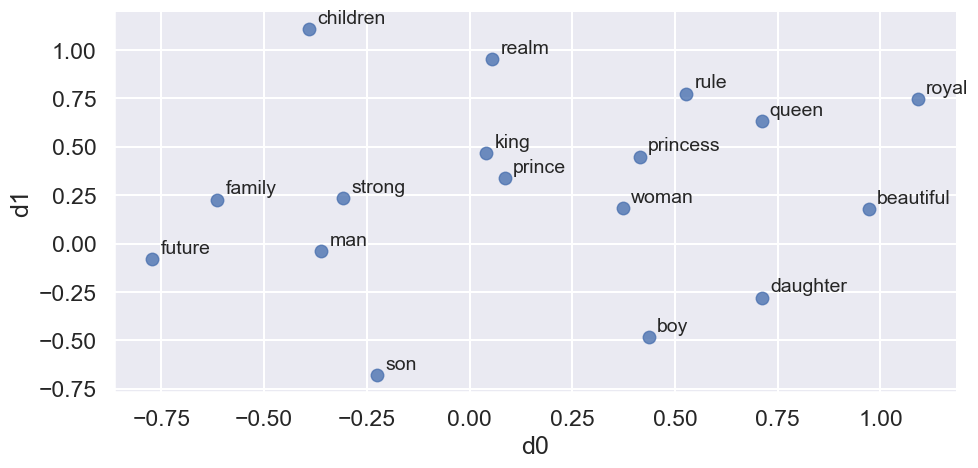

In [38]:
sns.lmplot(data=embedding2, x='d0', y='d1', fit_reg=False, aspect=2)
for token, vector in embedding2.iterrows():
    plt.gca().text(vector['d0']+.02, vector['d1']+.03, str(token), 
                   size=14)
plt.show()

Let's save the embeddings and load it with Gensim.

In [39]:
with open('embedding2.txt' ,'w') as text_file:
    text_file.write(f'{n_vocabulary} {dimension}\n')
    for token, vector in embedding2.iterrows():
        text_file.write(f"{token} {' '.join(map(str, vector))}\n")
text_file.close()
embedding2_loaded = KeyedVectors.load_word2vec_format('embedding2.txt', binary=False)
embedding2_loaded.most_similar(positive=['king'], topn=n)

[('realm', 0.9995501041412354),
 ('prince', 0.9869499206542969),
 ('children', 0.9105312824249268)]